In [0]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


In [0]:
device = torch.device("cuda")
np.random.seed(seed=33)

deeplab_resnet101 = torchvision.models.segmentation.deeplabv3_resnet101(pretrained=True).to(device)

normalize3 = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
normalize1 = torchvision.transforms.Normalize(mean=[0.485], std=[0.229])
transforms3 = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), normalize3])
transforms1 = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), normalize1])

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
rgb_data = Image.open('/content/gdrive/My Drive/Potsdam/top_potsdam_2_10_RGB.tif')
elevation_data = Image.open('/content/gdrive/My Drive/Potsdam/dsm_potsdam_02_10_normalized_lastools.jpg')
label_data = Image.open('/content/gdrive/My Drive/Potsdam/top_potsdam_2_10_label.tif')

In [0]:
def raw_labels_to_classes(dim):
  dim = list(dim)
  if dim == [0x00, 0xff, 0x00]:
    return 0 # tree
  elif dim == [0x00, 0xff, 0xff]:
    return 1 # ground
  elif dim == [0xff, 0x00, 0x00]:
    return 2 # clutter
  elif dim == [0x00, 0x00, 0xff]:
    return 3 # building
  elif dim == [0xff, 0xff, 0x00]:
    return 4 # car
  else:
    return 5 # nothing

def transmute_to_classes(window):
  # 2 = tree
  # 3 = ground
  # 4 = clutter
  # 1 = building
  # 5 = car
  # 0 = everything else
  retval = (4*(window[:, :, 0]/0xff).astype(np.long) + 2*(window[:, :, 1]/0xff).astype(np.long) + 1*(window[:, :, 2]/0xff).astype(np.long))
  retval = retval * (retval < 6)
  return retval

def random_potsdam_training_window(rgb_data, elevation_data, label_data):
  size = 224
  x = np.random.randint(0, 6000 - size)
  y = np.random.randint(0, 6000 - size)
  box = (x, y, x + size, y + size)
  rgb_window = rgb_data.crop(box)
  elevation_window = elevation_data.crop(box)
  labels_window = np.array(label_data.crop(box))
  labels_window = transmute_to_classes(labels_window)
  return (rgb_window, elevation_window, labels_window)

def random_potsdam_training_batch(rgb_ar, elevation_ar, labels_ar):
  batch_size = 64
  
  rgbs = []
  elvs = []
  labs = []
  
  for i in range(batch_size):
    rgb, elv, lab = random_potsdam_training_window(rgb_ar, elevation_ar, labels_ar)

    rgbs.append(transforms3(rgb))
    elvs.append(transforms1(elv))
    labs.append(torch.unsqueeze(torch.from_numpy(lab), 0))

  rgbs = torch.stack(rgbs).to(device)
  elvs = torch.stack(elvs).to(device)
  labs = torch.cat(labs, dim=0).to(device)

  return (rgbs, elvs, labs)


In [0]:
# Reshape Network for 6 Classes

last_class = deeplab_resnet101.classifier[4] = torch.nn.Conv2d(256, 6, kernel_size=(1,1), stride=(1,1))
last_class_aux = deeplab_resnet101.aux_classifier[4] = torch.nn.Conv2d(256, 6, kernel_size=(1,1), stride=(1,1))

deeplab_resnet101 = deeplab_resnet101.to(device)

In [0]:
# Feature Extraction Only

for p in deeplab_resnet101.parameters():
  p.requires_grad = False

for p in last_class.parameters():
  p.requires_grad = True

for p in last_class_aux.parameters():
  p.requires_grad = True


In [0]:
# Optimizer

ps = []
for n, p in deeplab_resnet101.named_parameters():
  if p.requires_grad == True:
    ps.append(p)
    
opt = torch.optim.SGD(ps, lr=0.01, momentum=0.9)

In [0]:
# Objective Function

obj = torch.nn.CrossEntropyLoss().to(device)

In [0]:
# Get a Batch

if False:
  import time

  before = time.time()
  batch = random_potsdam_training_batch(rgb_data, elevation_data, label_data)
  after = time.time()
  print(after - before)

In [0]:
# Train for One Step

if False:
  opt.zero_grad()
  pred = deeplab_resnet101(batch[0])
  loss = obj(pred.get('out'), batch[2])
  loss.backward()
  opt.step()

In [0]:
# Train

import time
import math

steps_per_epoch_per_image = int((6000 * 6000) / (224 * 224 * 64))
epochs = 40

deeplab_resnet101.train()
for i in range(epochs):
  for j in range(steps_per_epoch_per_image):
    batch_tensor = random_potsdam_training_batch(rgb_data, elevation_data, label_data)
    opt.zero_grad()
    pred = deeplab_resnet101(batch_tensor[0])
    loss = obj(pred.get('out'), batch_tensor[2]) + 0.4*obj(pred.get('aux'), batch_tensor[2])
    loss.backward()
    opt.step()
  print('epoch={} time={} loss={}'.format(i, time.time(), loss.item()))

epoch=0 time=1562786346.9702828 loss=1.4295002222061157
epoch=1 time=1562786365.9169793 loss=1.3570654392242432
epoch=2 time=1562786385.0456333 loss=1.5211758613586426
epoch=3 time=1562786404.2832434 loss=1.3449227809906006
epoch=4 time=1562786423.5869253 loss=1.3626405000686646
epoch=5 time=1562786442.9742548 loss=1.3964118957519531
epoch=6 time=1562786462.434789 loss=1.2326797246932983
epoch=7 time=1562786481.972954 loss=1.372281551361084
epoch=8 time=1562786501.6116414 loss=1.3241896629333496
epoch=9 time=1562786521.2226014 loss=1.3656468391418457
epoch=10 time=1562786540.814618 loss=1.385998010635376
epoch=11 time=1562786560.426417 loss=1.4397437572479248
epoch=12 time=1562786580.099636 loss=1.5550673007965088
epoch=13 time=1562786599.8112655 loss=1.3282606601715088
epoch=14 time=1562786619.4793453 loss=1.2202861309051514
epoch=15 time=1562786639.1185813 loss=1.3539979457855225
epoch=16 time=1562786658.7774892 loss=1.3743699789047241
epoch=17 time=1562786678.4336317 loss=1.47073590

---

In [0]:
deeplab_resnet101.eval()
out = deeplab_resnet101(batch_tensor[0])
out = out['out'].data.cpu().numpy()
out.shape

(64, 6, 224, 224)

In [0]:
index = 17

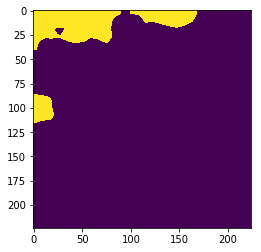

In [0]:
predicted_segments = np.apply_along_axis(np.argmax, 0, out[index])
plt.imshow(predicted_segments)

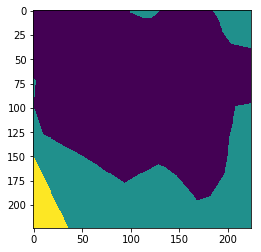

In [0]:
groundtruth_segments = batch_tensor[2].data.cpu().numpy()[index]
plt.imshow(groundtruth_segments)

In [0]:
torch.save(deeplab_resnet101, '/content/gdrive/My Drive/Potsdam/model')

In [0]:
!ls "/content/gdrive/My Drive/Potsdam/"


dsm_potsdam_02_10_normalized_lastools.jpg  top_potsdam_2_10_label.tif
model					   top_potsdam_2_10_RGB.tif
